# Spectroscopic Reduction Notes and Scripts
## ASTR 5150 HW 7
### by Brad Lyke

### Initial Linux Structure:
- The first step is to make the same subfolder structure as I did for photometry.
    - RAW includes the files as downloaded from the telescope.
    - SCI is only for science and CuAr frames
    - BIAS is for bias files
    - FLAT is for sky and dome flats
- I moved all of the files into the RAW folder, then copied files to their corresponding folder based on their identification in log.txt
    - cp t*.fits ./raw
    - cd raw
    - cp t0{01..12}.fits ../flat #Note that files t009 is missing.
    - cp t0{13..22}.fits ../bias
    - cp t0{23..56}.fits ../sci #Note that file t043 is missing

### Finding the Overscan and trimming
- I opened the t035.fits (random selection) and changed the scale to find the overscan.
- The overscan region is the same as it was for photometry:
    - Overscan left = [0:52]
    - Overscan right = [2101:2200]
    - In python's 0-indexed system: [0:53] + [2101:2200]
- See cell below for trimming the overscan using python

In [1]:
#Import all the things I'll need
from astropy.io import fits
import numpy as np
import numpy.polynomial.chebyshev as chb
import sys
import os
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['figure.figsize']=(20.0,10.0)
matplotlib.rc('font',size=20)

In [2]:
#Function for removing overscan from a single image. Call this with wrapper function.
def rem_oscan(infile):
    #Stuff goes here to remove the overscan
    sd = fits.open(infile)[0].data #opens the data for the image
    shdr = fits.open(infile)[0].header #opens the header for copying over`
    good_xpix = np.array([53,2100]) #The good, non-overscan pixels for WIRO Spec.
    out_array = np.zeros((2048,2048),dtype='int32') #holder array for good pixels
    overscan = np.zeros((2048,152),dtype='int32') #holder array for overscan pixels
    good_xarr = np.arange(good_xpix[0],good_xpix[1]+1,1) #Address range of good pix
    oscan_xarr = np.arange(0,2048,1)
    #This will copy the good pixels over to the out_array
    #overscan for each row will be fit to a 1st degree chebyshev polynomial.
    #This fit will then be removed from the good pixels
    for i in range(2048):
        out_array[i,:] = sd[i,good_xpix[0]:good_xpix[1]+1] #Copy over good pixels
        overscan[i,0:good_xpix[0]] = sd[i,0:good_xpix[0]] #Make array of overscan left pixel values
        overscan[i,good_xpix[0]:152] = sd[i,good_xpix[1]+1:2200] #Array of overscan right pixel values

    oscan_mean = np.zeros(2048,dtype='f4')
    for i in range(2048):
        oscan_mean[i] = np.mean(overscan[i,:])

    #Find polyfit parameters for row-mean overscan
    pm_chb = chb.chebfit(oscan_xarr,oscan_mean,1)
    oscan_fit = chb.chebval(oscan_xarr,pm_chb) #Make an array of fit values using row numbers
    for i in range(2048):
        out_array[i,:] = out_array[i,:] - oscan_fit[i] #Remove the overscan function from good pixels
    #All pixels in the y-direction are good.

    out_hdu = fits.PrimaryHDU(out_array,header=shdr) #Make a new HDU for image
    ofile_str = infile.replace('.fits','_z.fits') #Output file rename
    out_hdu.writeto(ofile_str) #Write out the file

In [4]:
#Now we call the rem_oscan for all of the files:
folders = np.array(['bias','flat','sci'])
num_folders = len(folders)
for i in range(num_folders):
    loc = './{}/'.format(folders[i])
    gb_files = '{}*.fits'.format(loc)
    flist = np.sort(glob.glob(gb_files))
    num_files = len(flist)
    for j in range(num_files):
        temp_file = flist[j]
        rem_oscan(temp_file)
    print('{} files are done.'.format(folders[i]))

bias files are done.
flat files are done.
sci files are done.


### Making A Master Bias
Now that the overscan trimming is done we need to make the masterbias file. Also done using python like we did in photometry.

There was only one set of bias images taken so we will only make one masterbias file. From photometric reduction we saw that a median combine worked the best. That's what we'll do here.

In [6]:
#Make a master median bias
#This is the function to call to make that file.
def mk_bias():
    file_loc = './bias/*_z.fits'
    file_list = glob.glob(file_loc)
    file_sort = np.sort(file_list)
    num_files = len(file_sort)
    bias_arr = np.zeros((2048,2048,num_files),dtype='f4')
    master_bias_arr = np.zeros((2048,2048),dtype='f4')
    #Make a 3D array for all of the bias files, each x/y plane is a file.
    for i in range(num_files):
        tfile_name = file_sort[i]
        temp_file = fits.open(tfile_name)[0].data
        bias_arr[:,:,i] = temp_file[:,:]
    #Take the median to make the master bias set.
    master_bias_arr = np.median(bias_arr,axis=2)
    
    mstbias_hdu = fits.PrimaryHDU(master_bias_arr) #Make a new HDU for image
    mstbias_str = './bias/masterbias_median.fits' #Output file rename
    mstbias_hdu.writeto(mstbias_str) #Write out the file
    print('Masterbias complete.')

In [7]:
mk_bias()

Masterbias complete.


Looking at the masterbias_median.fits file, it looks like it did well. I now need to remove this, by subtraction from all of the files.

In [23]:
def sub_bias():
    folders = np.array(['bias','flat','sci'])
    num_folders = len(folders)
    #open the master bias file we just made.
    mbias = fits.open('./bias/masterbias_median.fits')[0].data
    for i in range(num_folders):
        #make a file list for each type of file.
        loc = './{}/'.format(folders[i])
        gb_files = '{}*_z.fits'.format(loc)
        
        flist = np.sort(glob.glob(gb_files))
        num_files = len(flist)        
        for j in range(num_files):
            #open the current file and header
            print(flist[j])
            temp_file = fits.open(flist[j])[0].data
            temp_hdr = fits.open(flist[j])[0].header #opens the header for copying over`
            #makes a placeholder array for the subtraction
            out_array = np.zeros((2048,2048),dtype='int32') #holder array for good pixels
            out_array = temp_file - mbias
            
            out_hdu = fits.PrimaryHDU(out_array,header=temp_hdr) #Make a new HDU for image
            ofile_str = flist[j].replace('_z.fits','_zb.fits') #Output file rename
            out_hdu.writeto(ofile_str) #Write out the file
        print('{} files are done.'.format(folders[i]))

In [24]:
sub_bias()

./bias/t013_z.fits
./bias/t014_z.fits
./bias/t015_z.fits
./bias/t016_z.fits
./bias/t017_z.fits
./bias/t018_z.fits
./bias/t019_z.fits
./bias/t020_z.fits
./bias/t021_z.fits
./bias/t022_z.fits
bias files are done.
./flat/t001_z.fits
./flat/t002_z.fits
./flat/t003_z.fits
./flat/t004_z.fits
./flat/t005_z.fits
./flat/t006_z.fits
./flat/t007_z.fits
./flat/t008_z.fits
./flat/t010_z.fits
./flat/t011_z.fits
./flat/t012_z.fits
flat files are done.
./sci/t023_z.fits
./sci/t024_z.fits
./sci/t025_z.fits
./sci/t026_z.fits
./sci/t027_z.fits
./sci/t028_z.fits
./sci/t029_z.fits
./sci/t030_z.fits
./sci/t031_z.fits
./sci/t032_z.fits
./sci/t033_z.fits
./sci/t034_z.fits
./sci/t035_z.fits
./sci/t036_z.fits
./sci/t037_z.fits
./sci/t038_z.fits
./sci/t039_z.fits
./sci/t040_z.fits
./sci/t041_z.fits
./sci/t042_z.fits
./sci/t044_z.fits
./sci/t045_z.fits
./sci/t046_z.fits
./sci/t047_z.fits
./sci/t048_z.fits
./sci/t049_z.fits
./sci/t050_z.fits
./sci/t051_z.fits
./sci/t052_z.fits
./sci/t053_z.fits
./sci/t054_z.fits
.

I checked up on t035_zb.fits to make sure the bias was removed correctly. It looks like it has. Now all of the files have had overscan removed (\_z) and masterbias removed (\_zb).

### Making the Spectroscopic Flats

- This is a little more complicated than making the photometric flats. We now have dome flats, which are a little easier, but we need to make a "response" file and an "illum" file. The illum file is optional, so for right now we'll skip it and just make the "response" file. A lot of what we're doing here will now migrate over to IRAF. I'll copy the commands here, but little will be done in python directly.

- We only want to use the dome flats for this, so we'll look at t001 through t007. First we'll make a masterflat file like we did for photometry. We'll use a median combine with sigma clipping rejection, scaled by the mean, and weighted by the mean.
    - epar imcombine
    - input = @dflat.list #list I made of the dome flat \_zb files.
    - output = masterDflat.fits
    - combine = median
    - reject = sigclip
    - scale = mean
    - weight = mean
    - #run# imcombine

#### Output from imcombine:

```
combine = median, scale = mean, zero = none, weight = mean
reject = sigclip, mclip = yes, nkeep = 1
lsigma = 3., hsigma = 3.
blank = 0.
                Images     Mean  Scale Weight
           t001_zb.fits  1224.4  1.000  0.143
           t002_zb.fits  1223.5  1.001  0.143
           t003_zb.fits  1225.8  0.999  0.143
           t004_zb.fits  1216.5  1.006  0.142
           t005_zb.fits  1230.3  0.995  0.144
           t006_zb.fits  1216.4  1.007  0.142
           t007_zb.fits  1223.8  1.000  0.143

Output image = masterDflat.fits, ncombine = 7
```

In [31]:
#Found out I need to trim the images x and y to cut down to just the spectra.
#The good box for this is x[0:2048], y[700:1100]
#I'm going to try this on the masterDflat file and a science image to see if it works.

def slit_trim(infile):
    #sd = fits.open('./flat/masterDflat.fits')[0].data
    #shdr = fits.open('./flat/masterDflat.fits')[0].header
    sd = fits.open(infile)[0].data
    shdr = fits.open(infile)[0].header
    slit_pix = np.zeros((400,2048),dtype='f4')
    slit_pix[:,:] = sd[700:1100,:]
    
    #out_hdu = fits.PrimaryHDU(slit_pix,header=shdr) #Make a new HDU for image
    #ofile_str = './flat/masterTEST.fits'
    out_hdu = fits.PrimaryHDU(slit_pix,header=shdr) #Make a new HDU for image
    ofile_str = infile.replace('_zb.fits','_zbs.fits')
    out_hdu.writeto(ofile_str) #Write out the file

In [32]:
#Now we call the slit_trim for all of the files:
folders = np.array(['bias','flat','sci'])
num_folders = len(folders)
for i in range(num_folders):
    loc = './{}/'.format(folders[i])
    gb_files = '{}*_zb.fits'.format(loc)
    flist = np.sort(glob.glob(gb_files))
    num_files = len(flist)
    for j in range(num_files):
        temp_file = flist[j]
        slit_trim(temp_file)
    print('{} files are done.'.format(folders[i]))

bias files are done.
flat files are done.
sci files are done.


### Make the Response File

I used the following from the noao.twodspec.longslit package: (following iraf commands)
- noao
- twodspec
- longslit #All of these loaded the correct package
- epar response
    - calibrat = masterDflat.fits #The new one that had been trimmed down
    - normaliz = masterDflat.fits
    - response = rep02.fits
    - interact = yes
    - sample = 0:2048 #THIS WAS NECESSARY MY DEFAULTS WERE FOR SOME WEIRD RANGE
    - function = chebyshev
    - order = 70
    - high/lo reject = 3
    - ninter = 2
- response

This created rep02.fits

Then I needed to divide the response image from everything. I made two lists (finally using SED) and imarith with the response image. From the sci folder:
- ls t*\_zbs.fits > sci.list
- sed -e 's/zbs/zbsf/' sci.list >> sci_out.list
- (IRAF) imarith @sci.list ../flat/rep02.fits @sci_out.list

This generated the corrected science frames now.
Midpoint Note: \_z - overscan removed, \_zb - masterbias subtracted, \_zbs - removed unneeded rows above and below slit, \_zbsf - masterflat/response corrected.

### Aperture and 1D Spectra

I need to first add a header keyword DISPAXIS=1 to my fits headers so that APALL will know what the dispersion axis is. HEDIT in IRAF is the best tool for this. sci_out.list still has a list of all science frames.

In IRAF and APALL (in noao.twodspec.apextract) use the following commands:
- epar apall
    - input = filename.fits
    - output = filename_spec.fits
    - format = onedspec
    - referen = filename.fits
    - mark YES to all the following: interac, find, recente,resize,edit,trace,fittrac,extract,extras,bkg
- #run# apall
- use 's' to center the aperture window on the spike
- use 'b' to go into background mode.
- use 'z' to delete background options.
- use 's' on either side of the region you want for the background.
- use 'q' to save
- use 'q' and confirm all the things to get to the aperture fitting window.
- Chebyshev polynomial of order 10 (after deleting outliers with 'd') worked well.
- yes to evertyhing

I did this for the three images t034, t036, and t040. I also did it for the CuAr lamps (t035,t037,t041), but with the following differences in epar apall:
    - input = cuar_filename.fits
    - output = cuar_filename_spec.fits
    - referen = sci_filename.fits (this makes it use the right aperture window)
    - mark NO to the following: interac, find, recente,resize,edit,trace,bkg
    
This gave me spectra for three MT objects.

### Identifying Reference Spectra

- I had to get the new line lists (as I didn't remember the CuAr.dat we had) from:
http://iraf.noao.edu/specatlas/cuar/cuar.html
- After this, I downloaded a number of lamp spectra from the same location of various wavelength ranges.
- Then, in IRAF, I used the command:
    - epar identify #in noao.twodspec.longslit
    - referenc = my cuar frame (t037_zbsf_spec.0001.fits)
    - coordli = line_list.dat #saved from web in same folder as science data. Remember to delete first line from file
    - functio = chebyshev
    - order = 3 #to start
    - quit and save.
    - identify
- In identify I had to find a few confident lines first, then "f" for a fit. "d" deletes outliers, ":o x" increases the order of the fit (type "f" after). "q" goes back to the spectra.
- If, like mine, your emission lines all clump at the end, you either chose a fit of too high order, or one of the end points is bad. Delete and refit ("d" in the spectra view").
- Repeat the last two steps until you have a large number of confident lines.
- "q" to quit, then "yes" to save the spectra.

- I didn't want to redo the whole spectral identify again, so I used another tool, "reidentify".
- Use the following (still in noao.twodspec.longslit)
    - epar reidentify
    - referenc = t037_zbsf_spec.0001.fits #the file I did the first identify on
    - images = t035_zbsf_spec.0001.fits #the new file to reidentify
    - interac = yes
    - coorli = line_list.dat
    - verbose = yes
- Make sure the output new RMS is about the same as the last. On t037 my RMS = 0.0128, on reidentify for t035, my RMS = 0.0131. For t041 in reidentify my RMS = 0.0149 (a little off, but still low). You can use identify on the new spectra to check the fit. If you do "interact = yes" it will ask you to fix the fit in reidentify. Type "yes", then type "f" in the window. Delete an outlier and refit ("f"). I did this an t041 RMS = 0.0134 (much better).

Image|RMS
-|-
t035_zbsf_spec.0001|0.0131
t037_zbsf_spec.0001|0.0128
t041_zbsf_spec.0001|0.0149

### Applying the Wavelength Solution

- More IRAF commands. Once the refspectra are created, you need to use two commands in the onedspec package:
    - epar refspectra #in noao.onedspec
    - input = science frame #t036_zbsf_spec.0001.fits
    - referen = cuar frame #t037_zbsf_spec.0001.fits
    - select = match
    - This just addes something to the header to tell DISPCOR what the reference wavelength solution is.
    - refspectra
    - epar dispcor
    - input = @disp_in.list #A list file I made of the science images.
    - output = @disp_out.list #a list file I made of the output wavelength images. They are now name t###\_w.fits
    - dispcor
- Output from dispcor
```
t034_zbsf_spec.0001.fits: REFSPEC1 = 't035_zbsf_spec.0001 1.'
t034_w.fits: ap = 1, w1 = 5286.793, w2 = 6772.741, dw = 0.725915, nw = 2048
t036_zbsf_spec.0001.fits: REFSPEC1 = 't037_zbsf_spec.0001 1.'
t036_w.fits: ap = 1, w1 = 5296.469, w2 = 6772.432, dw = 0.721037, nw = 2048
t040_zbsf_spec.0001.fits: REFSPEC1 = 't041_zbsf_spec.0001 1.'
t040_w.fits: ap = 1, w1 = 5271.779, w2 = 6772.268, dw = 0.733018, nw = 2048
```
- The dw values are the Ang/pix dispersions for each.
- use splot to check the spectra on each. (They all looked good).

### Fitting the Continuum
- Again using IRAF, we want to use "continuum" in noao.onedspec.
    - epar continuum
    - input = t034_w.fits #My wavelength-solved image
    - output = t034_wc.fits #the output file
    - interac=yes #I want to reject pixels as necessary.
    - continuum
    - Here, use ":o #" to change the order of the fit. "j" to find residuals and "d" to delete points. Type "q" when ready to save the file.
    - splot t034_wc.fits to look at the new file.
    

In [5]:
#This script is to plot a science frame with and without the continuum fit

def spec_2plot(infile):
    data_file = infile
    cont_file = infile.replace('w.fits','wc.fits')
    sdata1 = fits.open(data_file)[0].data
    shdr1 = fits.open(data_file)[0].header
    sdata2 = fits.open(cont_file)[0].data
    start_wl = shdr1['CRVAL1']
    delta_wl = shdr1['CDELT1']
    wl = np.zeros(2048,dtype='f4')
    for i in range(2048):
        wl[i] = start_wl + (i * delta_wl)
    flux_data = sdata1
    flux_cont = sdata2
    
    x_lower = wl[0]
    x_upper = wl[2047]
    fig2,ax2 = plt.subplots(nrows=2,ncols=1,sharex='col',figsize=(15,12))
    ax2[0].plot(wl,flux_data,color='black',linewidth=0.8)
    ax2[1].plot(wl,flux_cont,color='black',linewidth=0.8)
    ax2[0].set_xlim((x_lower,x_upper))
    ax2[1].set_xlabel(r'Wavelength (\AA)',fontsize=20)
    ax2[0].set_ylabel('Rel. Flux',fontsize=20)
    ax2[1].set_ylabel('Rel. Flux',fontsize=20)
    for i in range(2):
        ax2[i].tick_params(axis='both',direction='in')
        ax2[i].tick_params(axis='both',which='minor',direction='in')
        ax2[i].tick_params(top=True,right=True)
        ax2[i].tick_params(which='minor',top=True,right=True)
    ax2[1].xaxis.set_major_locator(ticker.MultipleLocator(200))
    ax2[1].xaxis.set_minor_locator(ticker.MultipleLocator(10))
    fig2.subplots_adjust(wspace=0,hspace=0)

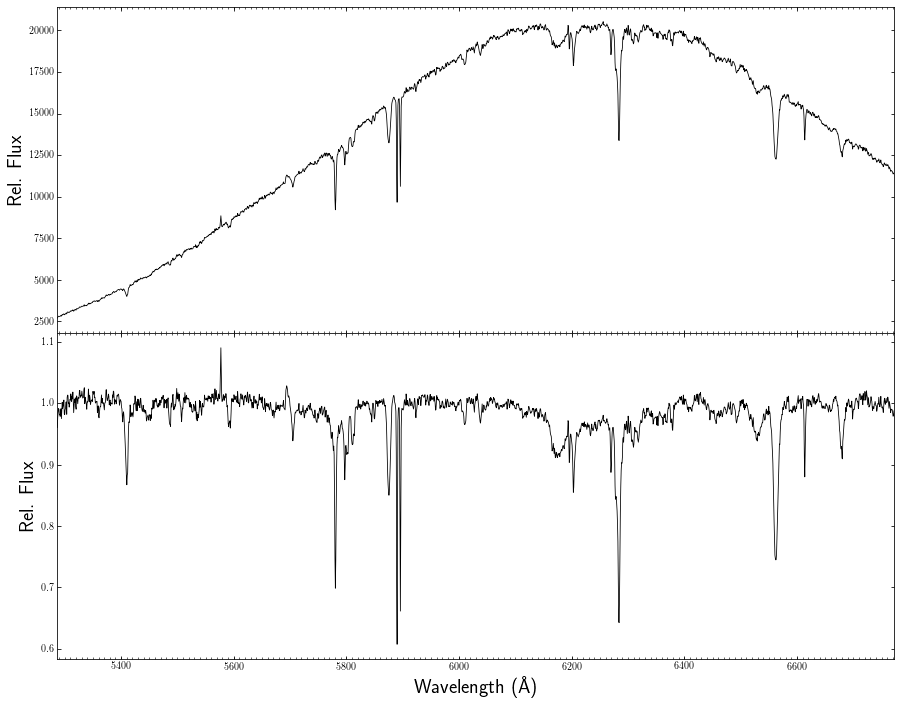

In [6]:
spec_2plot('./sci/t034_w.fits')

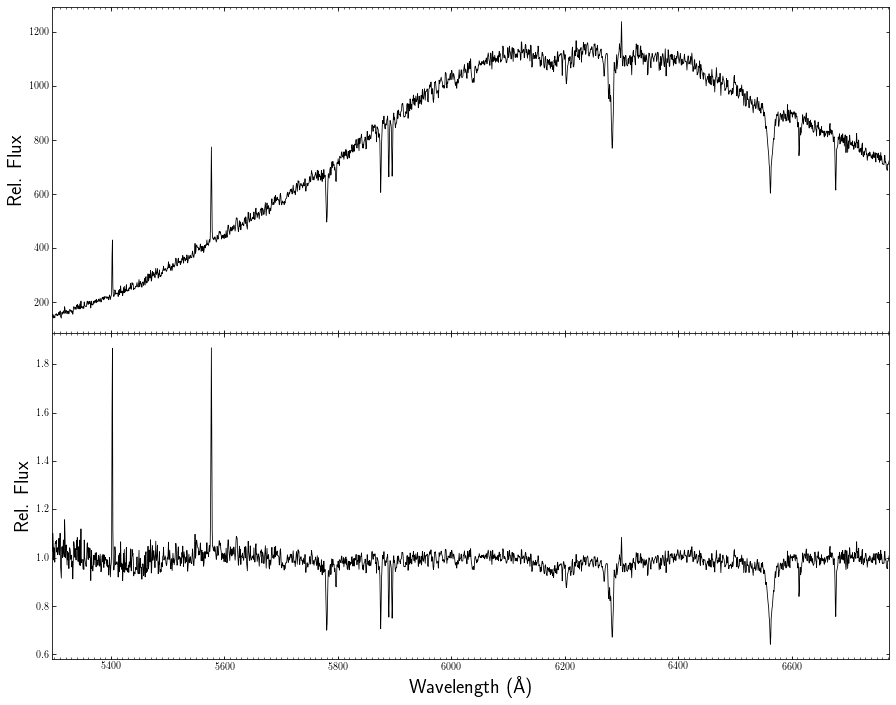

In [7]:
spec_2plot('./sci/t036_w.fits')

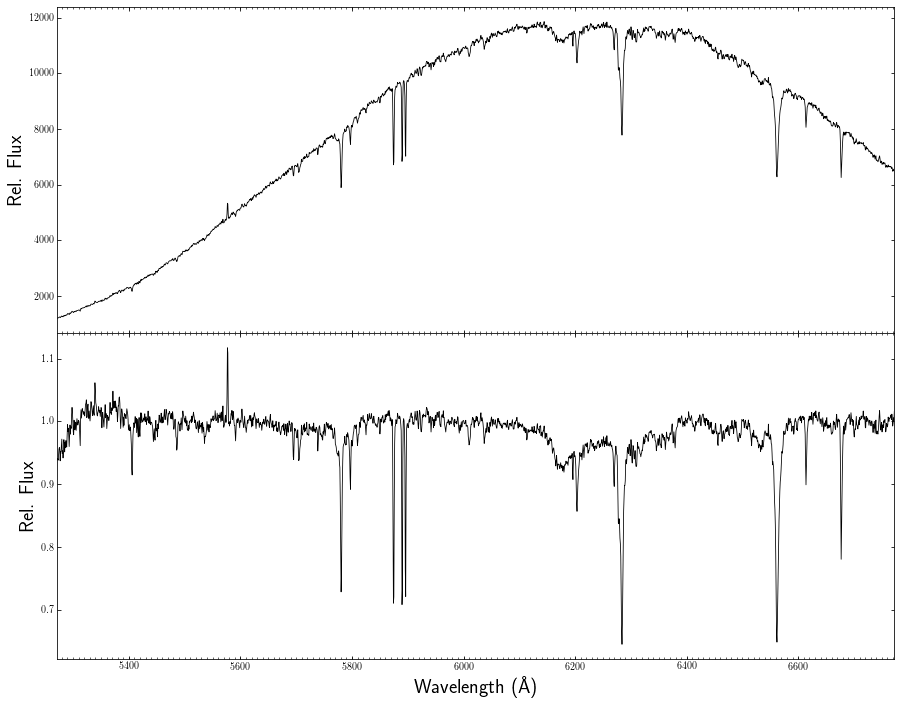

In [8]:
spec_2plot('./sci/t040_w.fits')

### Looking At Spectra

- In t036_wc.fits I looked at RMS of the continuum area around 6000 Ang.
- RMS = 0.01908, SNR = 52.38 (for the area from IRAF's splot)

For matching the spectra to the Jacoby Standard Stars, Jordan and I came up with a (possibly) better idea than trying to eyeball it, but it will take too much work to do right now.

If our spectrum is very close to a Jacoby spectrum, then diving it by all of the Jacoby spectrum and then looking at the mean and standard deviation for a range where we know there are no sky lines should give us a value for comparison. Hypothetically, the divided spectrum with the lowest standard deviation (and mean closest to 1) should be the best fit.

Unfortunately, the Jacoby spectra are differently scaled (Ang/pix) than the measured spectra we have. I could rescale the Jacoby spectra to ours, but this would require more work than I can do right now.

To classify one of the objects, I used splot \*.fits on all of the Jacoby Spectra. Then I narrowed it down to a B-type star. I used splot again as "splot B\*-n.fits xmin=5250 xmax=6750" and came up with the following list of stars that fit best:
- t034_wc.fits (MT299)
    - B0.5Ib-n
    - B1.5b-n
    - B3III-n